### Building a Simple Decision Tree:

#### In this tutorial we'll build a machine learning model that classifies molecules as soluble or insoluble. After building the model, we'll visualize the results.

In [2]:
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision trees
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats
from tdc.single_pred import ADME
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs

In [3]:
tqdm.pandas()

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

In [4]:
def calc_descriptors(mol):
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

The molecules in this dataset have a number of salts and other functionality that can create issues with descriptor calcuations. In order to avoid some of these problems we can use the function below to standardize the molecules.

In [5]:
def standardize(smiles):
    mol = Chem.MolFromSmiles(smiles)
     
    # remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to represent all molecules from different sources
    # in a (single) standard way, for use in ML etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

In [6]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()

Found local copy...
Loading...
Done!


Let's take a look at the input data, which has three columns

Drug_ID - the molecule name\
Drug - the SMILES\
Y - the log of the aqueous solubility in uM

In [7]:
sol_df

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


In [8]:
sol_df.columns = ["Name","SMILES","LogS"]
sol_df

,Name,SMILES,LogS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


In [9]:
sol_df = sol_df[['SMILES','Name','LogS']]
sol_df

,SMILES,Name,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065
...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000


Before we calculate descriptors, we're going to standardize the molecules. This process removes counterions, neutralizes molecules, and generates a standard tautomer. This process also generates a lot of logging output. We don't want to look at that output, so we're going to use the function BlockLogs to temporarily turn off logging. Once we're finished we delete the variable block and logging is back on.

In [10]:
block = BlockLogs()
sol_df['mol'] = sol_df.SMILES.progress_apply(standardize)
del block

100%|██████████| 9982/9982 [2:07:47<00:00,  1.30it/s]     


Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM

In [11]:
sol_df['IsSol'] = sol_df.LogS > math.log10(200 * 1e-6)
sol_df

,SMILES,Name,LogS,mol,IsSol
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,True
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,True
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,True
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,False
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,False
...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,True
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,True
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,True
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,False


Plot solubility as a sanity check

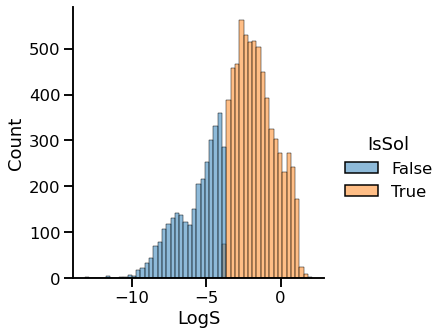

In [12]:
sns.set_context('talk') # Set the fonts the way I like them
sns.displot(x='LogS',hue="IsSol",data=sol_df)

Add the descriptors to the dataframe. Note that all the descriptors are going into one column called "desc".

In [13]:
sol_df['desc'] = sol_df.mol.progress_apply(calc_descriptors)

100%|██████████| 9982/9982 [00:34<00:00, 292.98it/s]


The function call in the cell above put all the descriptors into a single column called desc. We would like split the descriptors so that each is in its own column.

In [14]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.desc.to_list()

In [15]:
sol_df

,SMILES,Name,LogS,mol,IsSol,desc,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,True,"[312.60599999999994, 6.9541000000000075, 0, 0, 0]",312.606,6.95410,0.0,0.0,0.0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,True,"[169.18299999999996, 2.405500000000001, 2, 1, 1]",169.183,2.40550,2.0,1.0,1.0
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,True,"[140.569, 2.1525, 1, 0, 1]",140.569,2.15250,1.0,0.0,1.0
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,False,"[346.426, 5.3940000000000055, 3, 2, 2]",346.426,5.39400,3.0,2.0,2.0
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x000002BCB05...,False,"[422.52500000000026, 2.4854000000000003, 2, 0, 6]",422.525,2.48540,2.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,True,"[264.3689999999999, 2.617000000000001, 1, 1, 4]",264.369,2.61700,1.0,1.0,4.0
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,True,"[444.44000000000017, -1.4679999999999975, 1, 4...",444.440,-1.46800,1.0,4.0,9.0
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,True,"[150.221, 2.824020000000001, 1, 1, 1]",150.221,2.82402,1.0,1.0,1.0
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x000002BCB09...,False,"[454.6110000000002, 5.093080000000005, 2, 0, 6]",454.611,5.09308,2.0,0.0,6.0


We no longer need the "desc" column, let's get rid of it.

In [16]:
sol_df.drop("desc",axis=1,inplace=True)

In [20]:
sol_df

,SMILES,Name,LogS,mol,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x00000234AEA...,True,312.606,6.95410,0.0,0.0,0.0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x00000234AEA...,True,169.183,2.40550,2.0,1.0,1.0
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x00000234AEA...,True,140.569,2.15250,1.0,0.0,1.0
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x00000234AEA...,False,346.426,5.39400,3.0,2.0,2.0
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x00000234AEA...,False,422.525,2.48540,2.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x00000234AED...,True,264.369,2.61700,1.0,1.0,4.0
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x00000234AED...,True,444.440,-1.46800,1.0,4.0,9.0
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x00000234AED...,True,150.221,2.82402,1.0,1.0,1.0
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x00000234AED...,False,454.611,5.09308,2.0,0.0,6.0


In order to build a machine learning model, we will split the data into training and test sets. By default, the function train_test_split from scikit_learn puts 80% of the data into the training set and 20% into the test set.

In [17]:
train, test = train_test_split(sol_df)

Our data is currently in a Pandas dataframe. I find it easier to build models with X and y variables. We'll split the training and test sets into X and y variables.

In [18]:
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

In [19]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

In [21]:
cls.score(train_X,train_y)

0.8441090034731499

In [20]:
pred = cls.predict(test_X)
auc, mcc, kappa = roc_auc_score(test_y, pred),matthews_corrcoef(test_y,pred),cohen_kappa_score(test_y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.81
Matthews Correlation Coefficient = 0.63
Cohen's Kappa = 0.63


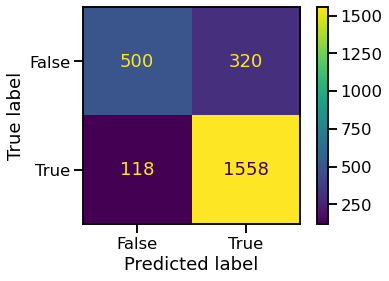

In [25]:
plot_confusion_matrix(cls,test_X,test_y)

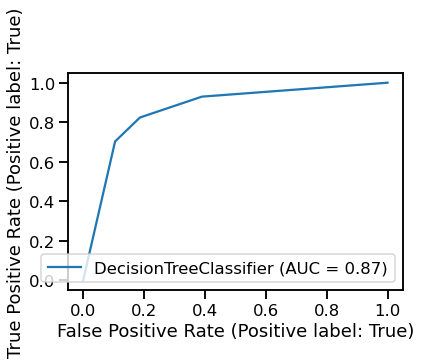

In [26]:
plot_roc_curve(cls,test_X,test_y)

[Text(0.5, 0.8333333333333334, 'LogP <= 2.729\ngini = 0.44\nsamples = 7486\nvalue = [2449, 5037]'),
 Text(0.25, 0.5, 'MW <= 268.275\ngini = 0.177\nsamples = 4678\nvalue = [458, 4220]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.126\nsamples = 3827\nvalue = [258, 3569]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.36\nsamples = 851\nvalue = [200, 651]'),
 Text(0.75, 0.5, 'LogP <= 3.562\ngini = 0.413\nsamples = 2808\nvalue = [1991, 817]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.5\nsamples = 908\nvalue = [442, 466]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.301\nsamples = 1900\nvalue = [1549, 351]')]

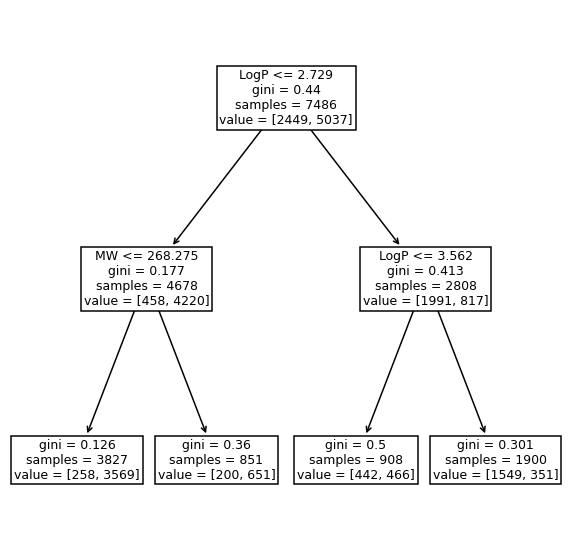

In [27]:
plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)

### Conclusion:

We have built a DT model to classify the compound as soluble or insoluble with ~84% of accuracy. 